In [327]:
import numpy as np
import scipy.io as sio
import argparse
from camera import Camera
from plotting import *

#### Crucial World View:

1. A universial world coordinate system exist.

2. The translation matrix T translate the point from world coordinate to camera coordinate.

3. P is M, the camera matrix.

4. It is assumed that silhouette can be obtained. (This imght be the tricky presumption of this carving method)

#### 1. Camera: 

P is camera matrix $P (=M) = K[R\,\,T]$

K is intrinsic camera matrix

R is rotation

T is translation matrix

The get_camera_direction function retrieve only the directional vector in 3D world coordinate of the line from camera center to the image center (camera axis).

In [328]:
class Camera:

    def __init__(self, K, P, true_silhouette):
        pass

    def __init__(self, frame):
        self.image = frame[0]
        self.P = frame[1]
        self.K = frame[2]
        self.R = frame[3]
        self.T = frame[4][:,0]
        self.silhouette = frame[6]

    # Get the unit vector for the direction of the camera
    def get_camera_direction(self):
        # this is supposed to correspond to image coordinate of the image center
        # x: image coordinate of the image center
        x = np.array([self.image.shape[1] / 2,
             self.image.shape[0] / 2,
             1])
        # this solves for the X where K@X = x, projection of image center in camera coordinate, X is a 3-dimensional vector, a 'directional vector' in 3D cooridnate
        X = np.linalg.solve(self.K, x)
        # R.T @ K^{-1} @ x = (K@R)^{-1} @ x = X
        X = self.R.transpose().dot(X)
        # return a normalized direction of (K @ R)^{-1} @ x
        return X / np.linalg.norm(X)

In [329]:
# These 'camera' class objects carry full information already, silhouette and all the other stuff
frames = sio.loadmat('frames.mat')['frames'][0]
cameras = [Camera(x) for x in frames]

In [330]:
# A very simple, but useful method to take the difference between the
# first and second element (usually for 2D vectors)
def diff(x):
    return x[1] - x[0]
"""
FORM_INITIAL_VOXELS  create a basic grid of voxels ready for carving

Truncation & Approximation: 
    We will decide bewteen adding some extra space by using more cubes to include
    all possible areas where the object reside in or truncating those space by using
    less cubes. 
    
    I would rather use more cubes since we will carve it out and no info will be lost.
    
    The other way around could jeopardize the effectiveness of the algorithms.

Arguments:
    xlim - The limits of the x dimension given as [xmin xmax]

    ylim - The limits of the y dimension given as [ymin ymax]

    zlim - The limits of the z dimension given as [zmin zmax]

    num_voxels - The approximate number of voxels we desire in our grid

Returns:
    voxels - An ndarray of size (N, 3) where N is approximately equal the 
        num_voxels of voxel locations.

    voxel_size - The distance between the locations of adjacent voxels
        (a voxel is a cube)
"""
xlim = np.array([1,11])
ylim = np.array([11,31])
zlim = np.array([3,11])
num_voxels = 50

def form_initial_voxels(xlim, ylim, zlim, num_voxels):
    # volumn of each voxels
    v = (diff(xlim) * diff(ylim) * diff(zlim)) / num_voxels
    # side length of each voxel / distance between adjacent voxel centers
    s = np.cbrt(v)
    # we will carve out useless part anyway so we add on a bit here
    nx,ny,nz = np.ceil(diff(xlim)/s), np.ceil(diff(ylim)/s), np.ceil(diff(zlim)/s)
    # center of each voxel's x y z coordinates
    vx,vy,vz = xlim[0]+s/2+s*np.arange(nx), ylim[0]+s/2+s*np.arange(ny), zlim[0]+s/2+s*np.arange(nz)
    # form a mesh grid in 3D
    meshs = np.meshgrid(vx, vy, vz)
    # construct voxels
    voxels = np.vstack((np.ravel(meshs[0]), np.ravel(meshs[1]), np.ravel(meshs[2]))).T
    # by definition
    voxel_size = s
    
    return voxels, voxel_size

#### Crucial World View:

4. Underground assumption: Let image center be $O_{I}$, camera center $O_{c}$, 3d point which project to camera center $P_{c}$ satisfies the relationship that direction of $O_{c}O_{I}$ is reverse of that of $O_{c}P_{c}$ 

5. Direct implication is the 'camera_direction' vector, which represent direction of $O_{c}O_{I}$ is the negative direction of $O_{c}P_{c}$, meaning the object's location should be $T - \text{Camera Range} \times \text{camera_direction}$

6. 'camera_range' seems to quantify clearly the distance between captured object and the camera center (in z_axis distance) which is VERY ODD and UNJUSTIFIED to me because I don't believe one can take any picture where all objects in it has same z-coordinate values under camera coordinate in 3d.

In [331]:
# Prcatically this might be the part where we should pay a lot of attention to
# Yet here the method of obtaining silhouette is given to us
'''
ESTIMATE_SILHOUETTE: Uses a very naive and color-specific heuristic to generate
the silhouette of an object

Arguments:
    im - The image containing a known object. An ndarray of size (H, W, C).

Returns:
    silhouette - An ndarray of size (H, W), where each pixel location is 0 or 1.
        If the (i,j) value is 0, then that pixel location in the original image 
        does not correspond to the object. If the (i,j) value is 1, then that
        that pixel location in the original image does correspond to the object.
'''
def estimate_silhouette(im):
    return np.logical_and(im[:,:,0] > im[:,:,2], im[:,:,0] > im[:,:,1] )

In [332]:
'''
CARVE: carves away voxels that are not inside the silhouette contained in 
    the view of the camera. The resulting voxel array is returned.
    Note that the image has shape (H,W), and so should be indexed (y,x)

Arguments:  (Note that the voxel size is NOT considered here at all....)
    voxels - an Nx3 matrix where each row is the location of a cubic voxel

    camera - The camera we are using to carve the voxels with. Useful data
        stored in here are the "silhouette" matrix, "image", and the
        projection matrix "P". 

Returns:
    voxels - a subset of the argument passed that are inside the silhouette
    
    
Remark:
    Some caveat in the rounding step should be noted
    When getting rid of outside image point, we shoudn't filter out points with <height,<width values
    Which makes the rounding before inside image filter a bad choice ! 
'''
def carve(voxels, camera):
    # silhouette of camera
    sil = camera.silhouette
    # project voxels to image and round to integer pixels coordiante
    homo_3d_voxels = np.pad(voxels.T, ((0,1),(0,0)), constant_values=1)
    homo_2d_projs = (camera.P @ homo_3d_voxels).T
    voxels_projs = homo_2d_projs[:,:2] / homo_2d_projs[:,2:]
    # round to integer while reversing x&y axis
    rounded_projs = np.round(voxels_projs).astype(int)[:,::-1]
    # there are points outside the image (which we put silhouette), filter out
    # projectionswhich are inside the image
    proj_inim = rounded_projs[(rounded_projs[:,0]>=0) * (rounded_projs[:,0]<sil.shape[0]) * (0<=rounded_projs[:,1]) * (rounded_projs[:,1]<sil.shape[1])]
    voxels_inim = voxels[(rounded_projs[:,0]>=0) * (rounded_projs[:,0]<sil.shape[0]) * (0<=rounded_projs[:,1]) * (rounded_projs[:,1]<sil.shape[1])]
    # record only projections within silhoutte
    proj_insi = proj_inim[sil[(proj_inim[:,0], proj_inim[:,1])]==1]
    voxels_insi = voxels_inim[sil[(proj_inim[:,0], proj_inim[:,1])]==1]

    return voxels_insi

In [338]:
'''
GET_VOXEL_BOUNDS: Gives a nice bounding box in which the object will be carved
from. We feed these x/y/z limits into the construction of the inital voxel
cuboid. 

Arguments:
    cameras - The given data, which stores all the information
        associated with each camera (P, image, silhouettes, etc.)

    estimate_better_bounds - a flag that simply tells us whether to set tighter
        bounds. We can carve based on the silhouette we use.

    num_voxels - If estimating a better bound, the number of voxels needed for
        a quick carving.

Returns:
    xlim - The limits of the x dimension given as [xmin xmax]

    ylim - The limits of the y dimension given as [ymin ymax]

    zlim - The limits of the z dimension given as [zmin zmax]
'''

def get_voxel_bounds(cameras, estimate_better_bounds = False, num_voxels = 4000):
    # extracting translation matrices from these cameras, the relative position of camera to world coordinate origin
    camera_positions = np.vstack([c.T for c in cameras])
    xlim = [camera_positions[:,0].min(), camera_positions[:,0].max()]
    ylim = [camera_positions[:,1].min(), camera_positions[:,1].max()]
    zlim = [camera_positions[:,2].min(), camera_positions[:,2].max()]

    # For the zlim we need to see where each camera is looking
    # Camera range: longest distance where camera captures object clearly? 
    # The captured object of interest reside between z-axis of 0 (camera center) to 'camera_range' distance
    # along the camera direction, the camera axis extending from camera center to the object (reverse of image)
    camera_range = 0.6 * np.sqrt(diff( xlim )**2 + diff( ylim )**2)
    for c in cameras:
        viewpoint = c.T - camera_range * c.get_camera_direction()
        zlim[0] = min( zlim[0], viewpoint[2] )
        zlim[1] = max( zlim[1], viewpoint[2] )

    # Move the limits in a bit since the object must be inside the circle
    # Detail: extend both the upper & lower limit by one fourth of its original range
    xlim = xlim + diff(xlim) / 4 * np.array([1, -1])
    ylim = ylim + diff(ylim) / 4 * np.array([1, -1])

    if estimate_better_bounds:
        # initialize voxels with limit & voxels number
        voxels, voxel_size = form_initial_voxels(xlim,ylim,zlim,num_voxels)
        # using all cameras to refine on voxels which project inside silhouette
        for c in cameras:
            voxels = carve(voxels, c)
        # Use the resulting voxels to update on the xlim,ylim,zlim at the end
        lower, upper = voxels-voxel_size*1.5, voxels+voxel_size*1.5
        lus = np.vstack((lower.min(axis=0), upper.max(axis=0)))
        xlim, ylim, zlim = lus[:,0], lus[:,1], lus[:,2]
        
    return xlim, ylim, zlim

#### Report Including:
1. Initial Voxels in 3D.
2. Truncated Voxels after initial Carving (Using only image from the frist camera)
3. Final carving result (truncated Voxels)

#### (a). Using true silhouette and corase bounds

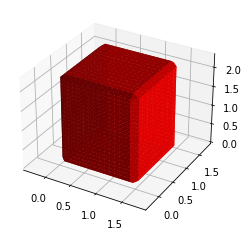

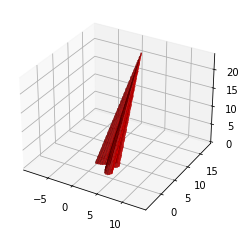

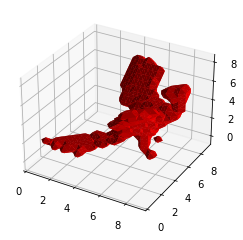

In [335]:
estimate_better_bounds = False
use_true_silhouette = True
frames = sio.loadmat('frames.mat')['frames'][0]
cameras = [Camera(x) for x in frames]

# Generate the silhouettes based on a color heuristic
if not use_true_silhouette:
    for i, c in enumerate(cameras):
        c.true_silhouette = c.silhouette
        c.silhouette = estimate_silhouette(c.image)
        if i == 0:
            plt.figure()
            plt.subplot(121)
            plt.imshow(c.true_silhouette, cmap = 'gray')
            plt.title('True Silhouette')
            plt.subplot(122)
            plt.imshow(c.silhouette, cmap = 'gray')
            plt.title('Estimated Silhouette')
            plt.show()

# Generate the voxel grid
# You can reduce the number of voxels for faster debugging, but
# make sure you use the full amount for your final solution
num_voxels = 6e6
xlim, ylim, zlim = get_voxel_bounds(cameras, estimate_better_bounds)

# This part is simply to test forming the initial voxel grid
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, 4000)
plot_surface(voxels)
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, num_voxels)

# Test the initial carving
voxels = carve(voxels, cameras[0])
if use_true_silhouette:
    plot_surface(voxels)

# Result after all carvings
for c in cameras:
    voxels = carve(voxels, c)  
plot_surface(voxels, voxel_size)

#### (b). Using true silhouette and betterbounds

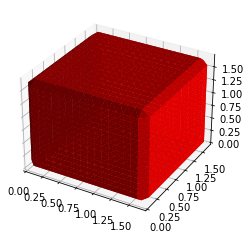

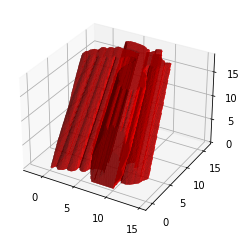

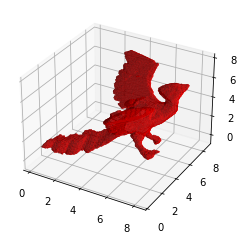

In [340]:
estimate_better_bounds = True
use_true_silhouette = True
frames = sio.loadmat('frames.mat')['frames'][0]
cameras = [Camera(x) for x in frames]

# Generate the silhouettes based on a color heuristic
if not use_true_silhouette:
    for i, c in enumerate(cameras):
        c.true_silhouette = c.silhouette
        c.silhouette = estimate_silhouette(c.image)
        if i == 0:
            plt.figure()
            plt.subplot(121)
            plt.imshow(c.true_silhouette, cmap = 'gray')
            plt.title('True Silhouette')
            plt.subplot(122)
            plt.imshow(c.silhouette, cmap = 'gray')
            plt.title('Estimated Silhouette')
            plt.show()

# Generate the voxel grid
# You can reduce the number of voxels for faster debugging, but
# make sure you use the full amount for your final solution
num_voxels = 6e6
xlim, ylim, zlim = get_voxel_bounds(cameras, estimate_better_bounds)

# This part is simply to test forming the initial voxel grid
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, 4000)
plot_surface(voxels)
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, num_voxels)

# Test the initial carving
voxels = carve(voxels, cameras[0])
if use_true_silhouette:
    plot_surface(voxels)

# Result after all carvings
for c in cameras:
    voxels = carve(voxels, c)  
plot_surface(voxels, voxel_size)

#### (c). Using estimated silhouette and better bounds

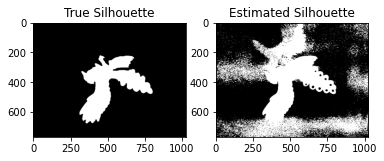

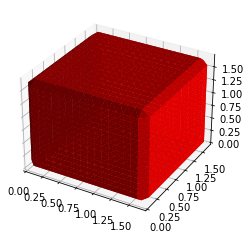

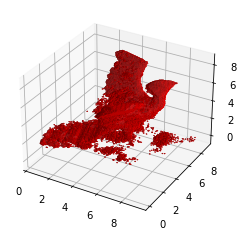

In [341]:
estimate_better_bounds = True
use_true_silhouette = False
frames = sio.loadmat('frames.mat')['frames'][0]
cameras = [Camera(x) for x in frames]

# Generate the silhouettes based on a color heuristic
if not use_true_silhouette:
    for i, c in enumerate(cameras):
        c.true_silhouette = c.silhouette
        c.silhouette = estimate_silhouette(c.image)
        if i == 0:
            plt.figure()
            plt.subplot(121)
            plt.imshow(c.true_silhouette, cmap = 'gray')
            plt.title('True Silhouette')
            plt.subplot(122)
            plt.imshow(c.silhouette, cmap = 'gray')
            plt.title('Estimated Silhouette')
            plt.show()

# Generate the voxel grid
# You can reduce the number of voxels for faster debugging, but
# make sure you use the full amount for your final solution
num_voxels = 6e6
xlim, ylim, zlim = get_voxel_bounds(cameras, estimate_better_bounds)

# This part is simply to test forming the initial voxel grid
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, 4000)
plot_surface(voxels)
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, num_voxels)

# Test the initial carving
voxels = carve(voxels, cameras[0])
if use_true_silhouette:
    plot_surface(voxels)

# Result after all carvings
for c in cameras:
    voxels = carve(voxels, c)  
plot_surface(voxels, voxel_size)